# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


## OUR PROBLEM STATEMENT

"WILL A CUSTOMER RESPOND TO AN OFFER"

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## DATA CLEANING

I will perform both tasks of Data Cleaning and Data Exploration in this section.

When we explore the data using various graphs plotted among different variables, and other plots like correlation matrices, we get a lot of information about the next steps of the process, called Data Engineering.

### 1. Portfolio dataset

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [5]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

#### OBSERVATION
It is a good thing that we do not have a lot NULL or NaN values in our portfolio.json file

### 2. Profile dataset

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### OBSERVATION
In this file "profile.json", we have 2175 NULL and NaN values. After a quick review of the data, it seems like "gender" and "income" was not a required field when the data was being collected.

### 3. Transcript dataset

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

#### OBSERVATION
transcript.json is also a very clean file. We do not have to preprocess it a lot to make it useful

We could define our functions here (which I did before), but this would make things very messy here. It is a good engineering practice to split up code into multiple files and group the functions on the basis of their similarity and use. This makes the software testing much easier.

### Data Cleaning and Exploration- portfolio dataset

First, we will perform data cleaning on the portfolio dataset.

In [14]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [15]:
portfolio['offer_type'].nunique()

3

In [16]:
max(portfolio['channels'])

['web', 'email', 'mobile', 'social']

#### OBSERVATION

We have 3 types of offers in the portfolio dataset. Since no offer is fundamentally better than the other one, we have to create one hot encoding for the "offer_type" column, which will generate 3 columns, ['bogo','informational','discount']. 

Similarly, as shown above, there are 4 types of media channels through which the offer was communicated. We must perform One Hot Encoding here as well.

I could have also performed "dummy variable" operation here just as easily, but in my opinion and my personal experience, one hot encoding give a little more clarity to the code. One hot encoding encodes the data into "kn" number of additional columns while using dummy variables instead encodes the data into kn-k number of additional columns. Please refer to the following link for further clarification. https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn

Furthermore, since the "id" in the "portfolio.json" dataset refers to the offer id, this may get confused with the user id in the "profile.json" dataset. For the sake of clarity, I am going to change the names of both columns to "offer_id" and "customer_id".

In [17]:
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [18]:
# Making the offer_id column as the 1st column in the table, and puting the columns which need one hot encoding at the end of the database.
# Reference: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns

portfolio = portfolio[['offer_id', 'difficulty', 'duration', 'reward', 'offer_type', 'channels']]

In [19]:
portfolio.head()

,offer_id,difficulty,duration,reward,offer_type,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,bogo,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,bogo,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,0,4,0,informational,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,bogo,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,discount,"[web, email]"


#### One Hot Encoding

In Pandas, we use pd.get_dummies(df[<column_name>]) to get one hot encoded variables. Although one hot encoding and dummy variables are different as mentioned above, in Pandas get_dummies gives us one hot encoding variables, but if we use another argument "drop_first=True", then we get true dummy variables.

Source:
http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example


In [20]:
offer_type_ohe = pd.get_dummies(portfolio['offer_type'])
offer_type_ohe

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [21]:
type(offer_type_ohe)

pandas.core.frame.DataFrame

In [22]:
# Now, we have to add this set of one hot encoded columns into the main portfolio database
portfolio2 = pd.concat([portfolio, offer_type_ohe], axis=1)

In [23]:
portfolio2.drop(columns=['offer_type'], inplace=True)
portfolio2

,offer_id,difficulty,duration,reward,channels,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,"[email, mobile, social]",1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,"[web, email, mobile, social]",1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,"[web, email, mobile]",0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,"[web, email, mobile]",1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,"[web, email]",0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,"[web, email, mobile, social]",0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,"[web, email, mobile, social]",0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,"[email, mobile, social]",0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,"[web, email, mobile, social]",1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,"[web, email, mobile]",0,1,0


In [24]:
# Since one person may be contacted via email,messages,social,or web, we cannot perform simple one hot encoding.
# We have to perform a different operation called "MultiLabelBinarizer"

# Source: https://stackoverflow.com/questions/53494873/transform-pandas-data-frame-to-use-for-multilabelbinarizer

from sklearn.preprocessing import MultiLabelBinarizer

In [25]:
mlb = MultiLabelBinarizer()
mlb.fit(portfolio2['channels'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [26]:
# Pandas does not create a new datafrema for MultiLabelBionarizer, so we have to create a new one.

channels_df = pd.DataFrame(mlb.transform(portfolio2['channels']), columns=mlb.classes_)

In [27]:
channels_df

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [28]:
portfolio2 = pd.concat([portfolio2, channels_df], axis=1)
portfolio2

,offer_id,difficulty,duration,reward,channels,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,"[email, mobile, social]",1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,"[web, email, mobile, social]",1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,"[web, email, mobile]",0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,"[web, email, mobile]",1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,"[web, email]",0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,"[web, email, mobile, social]",0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,"[web, email, mobile, social]",0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,"[email, mobile, social]",0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,"[web, email, mobile, social]",1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,"[web, email, mobile]",0,1,0,1,1,0,1


In [29]:
portfolio2.drop(columns=['channels'], inplace=True)
portfolio2

,offer_id,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


In [30]:
portfolio = portfolio2

In [31]:
portfolio

,offer_id,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


### Data Cleaning and Exploration - Customer profiles

Here, we will clean and explore the dataset of the customer details, the "profile" dataset. We have already imported this dataset above.

In [32]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [33]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


#### OBSERVATIONS

It turns out that there is a little problem with the age column. The max value here is 118, which is a bit odd as someone that old most likely will not be a customer and that could be a mistake when that customer was making his/her profile in the app/

In [34]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [35]:
profile.shape

(17000, 5)

Here, we can see that there are 2175 users with no gender or income information. This is (2175/17000)*100 = 12.79% of the total dataset.

Now, we will explore when did our customers joined our app and became members. 

In the dataset, date is given as an integer. We need to convert it to proper date type, which pandas can understand. We will apply "datetime" to just one column of the dataset, i.e. became_member_on

Reference: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime

In [36]:
from datetime import datetime

In [37]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

In [38]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


Now, our dates column has been converted to a proper date type, we will sum the number of members based on the year joined.

In [39]:
joining_year = profile['became_member_on'].apply(lambda x: x.year).value_counts()

In [40]:
joining_year

2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on, dtype: int64

In [41]:
total_members = joining_year.sum()
joining_year *= 100 / total_members
joining_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

The above output tells us that we had the most members signed up in 2017. The number of members joining in 2018 dipped by ~14%. This could be because of new competition in the coffee space or there are not many attractive offers/incentives available for the new customers to become members.

Now, let's see which month did our new customers decided to join the most.

In [42]:
joining_month = profile['became_member_on'].apply(lambda x: x.month).value_counts()
total_months = joining_month.sum()
joining_month *= 100 / total_months
joining_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

August is the most common month in which our members joined. 

#### EXPLANATION
This could be explained by the start of the new college year and the presence of Starbucks on most college campuses.

October and December are the colder months and are no brainer here. Coffee intake increases by a lot in the winter months.

### "profile" dataset cleaning

Now we have to perform the same cleaning steps as we performed on the Portfolio dataset above. I will try to group together as many functions as possible in single cell.

It would be ideal if I built a function to perform all the tasks of data cleaning at once.

First of all, we will start by dropping all the NULL column.

### Good Practice
If our data is reasonable in size, it is always a good practice to perform all data processing on a copy dataset, and once satisfied, replace the original dataset with the new, processed dataset.

In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
profile1 = profile.dropna()
profile1.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [45]:
profile1.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


For ease of data processing, we will drop all the customers where gender is not specified.

In [46]:
profile1 = profile1[profile1['gender'] != 'O']

In [47]:
profile1.describe()

,age,income
count,14613.000000,14613.000000
mean,54.393417,65435.707931
std,17.400201,21633.524110
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [48]:
profile1 = profile1[profile1['income'].notnull()]
profile1.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [49]:
profile1.rename(columns={'id':'customer_id'}, inplace=True)
profile1.head()

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [50]:
# Rearranging the columns
profile1 = profile1[['customer_id', 'gender', 'income', 'became_member_on', 'age']]
profile1.head()

,customer_id,gender,income,became_member_on,age
1,0610b486422d4921ae7d2bf64640c50b,F,112000.0,2017-07-15,55
3,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,2017-05-09,75
5,e2127556f4f64592b11af22de27a7932,M,70000.0,2018-04-26,68
8,389bc3fa690240e798340f5a15918d5c,M,53000.0,2018-02-09,65
12,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,2017-11-11,58


Now, we have to convert the gender column to binary, i.e. F=0, M=1.
We will also convert the "became_member_on" column to one hot encoded set of 6 years, split by the years.

In [51]:
profile1['membership_start_year'] = profile1['became_member_on'].apply(lambda x: x.year)
profile1.head()

,customer_id,gender,income,became_member_on,age,membership_start_year
1,0610b486422d4921ae7d2bf64640c50b,F,112000.0,2017-07-15,55,2017
3,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,2017-05-09,75,2017
5,e2127556f4f64592b11af22de27a7932,M,70000.0,2018-04-26,68,2018
8,389bc3fa690240e798340f5a15918d5c,M,53000.0,2018-02-09,65,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,2017-11-11,58,2017


In [52]:
# Because we removed a lot of data from our dataset, we should reset our index now

profile1 = profile1.reset_index(drop=True)
profile1.head()

,customer_id,gender,income,became_member_on,age,membership_start_year
0,0610b486422d4921ae7d2bf64640c50b,F,112000.0,2017-07-15,55,2017
1,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,2017-05-09,75,2017
2,e2127556f4f64592b11af22de27a7932,M,70000.0,2018-04-26,68,2018
3,389bc3fa690240e798340f5a15918d5c,M,53000.0,2018-02-09,65,2018
4,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,2017-11-11,58,2017


In [53]:
profile1.drop(columns=['became_member_on'], inplace=True)
profile1.head()

,customer_id,gender,income,age,membership_start_year
0,0610b486422d4921ae7d2bf64640c50b,F,112000.0,55,2017
1,78afa995795e4d85b5d9ceeca43f5fef,F,100000.0,75,2017
2,e2127556f4f64592b11af22de27a7932,M,70000.0,68,2018
3,389bc3fa690240e798340f5a15918d5c,M,53000.0,65,2018
4,2eeac8d8feae4a8cad5a6af0499a211d,M,51000.0,58,2017


In [54]:
from sklearn.preprocessing import LabelBinarizer

In [55]:
# Gender label binarizer

label_bin_gender = LabelBinarizer()
profile1['gender'] = label_bin_gender.fit_transform(profile1['gender'])

In [56]:
profile1.head()

,customer_id,gender,income,age,membership_start_year
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,55,2017
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,75,2017
2,e2127556f4f64592b11af22de27a7932,1,70000.0,68,2018
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,65,2018
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,58,2017


In [57]:
membership_start_year_ohe = pd.get_dummies(profile1['membership_start_year'])
membership_start_year_ohe

,2013,2014,2015,2016,2017,2018
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,1,0
5,0,0,0,0,1,0
6,0,1,0,0,0,0
7,0,0,0,1,0,0
8,0,1,0,0,0,0
9,0,0,0,0,1,0


In [58]:
# Appending the above DataFrame to our profile1 DataFrame
profile2 = pd.concat([profile1, membership_start_year_ohe], axis=1)
profile2.head()

,customer_id,gender,income,age,membership_start_year,2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,55,2017,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,75,2017,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,68,2018,0,0,0,0,0,1
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,65,2018,0,0,0,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,58,2017,0,0,0,0,1,0


In [59]:
profile2.drop(columns=['membership_start_year'], inplace=True)

In [60]:
# Now, in order to segment the age column into bins, we will use pd.cut. This will make the processing easier for us. We will then one hot encode these variables as well.

min_age_in_data = np.int(np.floor(np.min(profile2['age'])/10)*10)
max_age_in_data = np.int(np.ceil(np.max(profile2['age'])/10)*10)

profile2['age_buckets'] = pd.cut(profile2['age'], (range(min_age_in_data, max_age_in_data + 10, 10)), right=False)

profile2['age_buckets'] = profile2['age_buckets'].astype('str')


In [61]:
age_buckets_ohe = pd.get_dummies(profile2['age_buckets'])
age_buckets_ohe.head()

,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [62]:
profile2 = pd.concat([profile2, age_buckets_ohe], axis=1)
profile2.head()

,customer_id,gender,income,age,2013,2014,2015,2016,2017,2018,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,55,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,75,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,68,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,65,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,58,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [63]:
profile2.drop(columns=['age'], inplace=True)
profile2.head()

,customer_id,gender,income,2013,2014,2015,2016,2017,2018,age_buckets,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,"[50, 60)",0,0,0,0,0,1,0,0,0,0


In [64]:
profile2.drop(columns=['age_buckets'], inplace=True)
profile2.head()

,customer_id,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [65]:
profile = profile2
profile.head()

,customer_id,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


## Exploratory Data Analysis (EDA)

Now, from this point onwards, we will perform Exploratory Data Analysis of our dataset.

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Memberships per year - Male and Female

In [67]:
gender_integer_map = {'F':0, 'M':1}

In [68]:
print(gender_integer_map)

{'F': 0, 'M': 1}


In [69]:
profile1.head()

,customer_id,gender,income,age,membership_start_year
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,55,2017
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,75,2017
2,e2127556f4f64592b11af22de27a7932,1,70000.0,68,2018
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,65,2018
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,58,2017


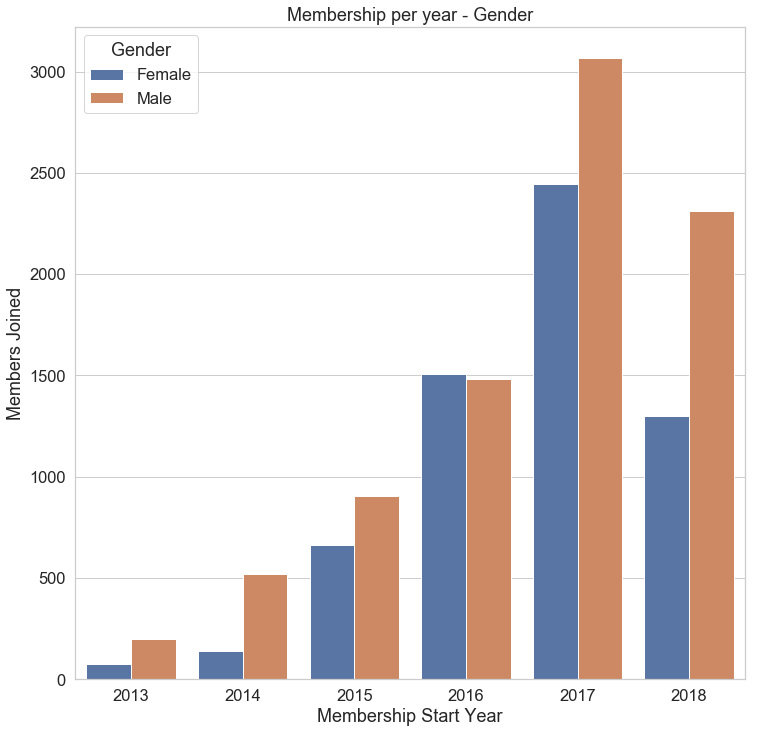

In [70]:
sns.set(style='whitegrid', font_scale=1.5, rc={'figure.figsize':(12,12)})

ax = sns.countplot(x='membership_start_year', hue='gender', data=profile1)

plt.xlabel('Membership Start Year')
plt.ylabel('Members Joined')
plt.title('Membership per year - Gender')
plt.legend(title='Gender', loc='upper left', labels=['Female', 'Male'])



#### OBSERVATION

From the above barchart, it looks like that except for the year 2016, in every year, we have more male signups than female signups. Also, from the year 2017 to 2018, female signups shrunk significantly more than the male signups.

###  Member Income Distribution with respect to Gender

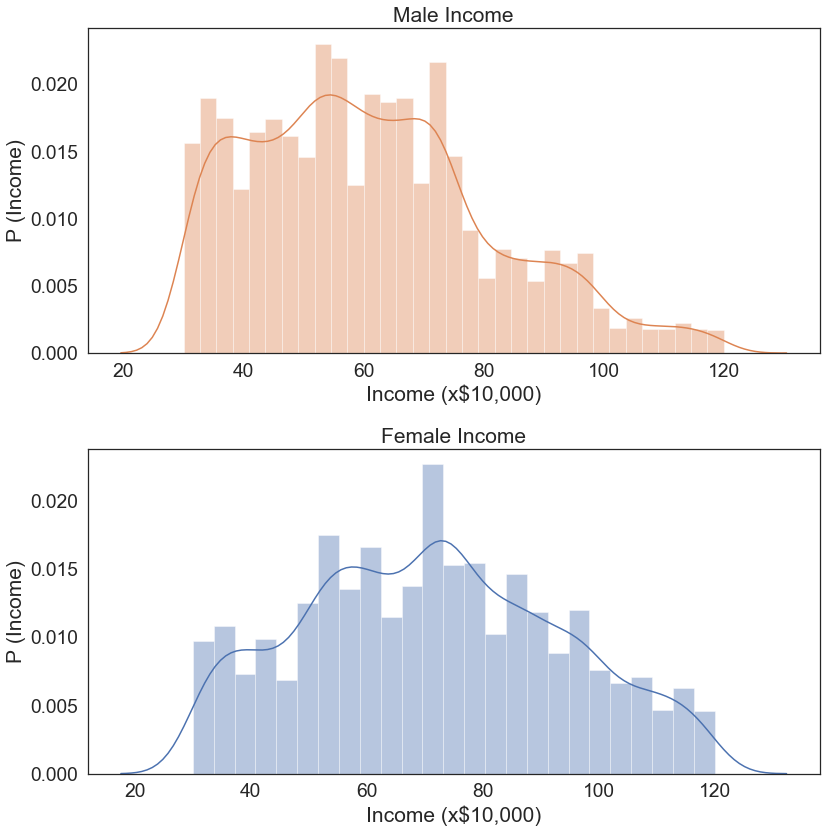

In [71]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]

current_palette = sns.color_palette()

sns.set(font_scale=1.75)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=1)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income (x$10,000)')
plt.ylabel('P (Income)')
plt.title('Male Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income (x$10,000)')
plt.ylabel('P (Income)')
plt.title('Female Income')
plt.tight_layout()

### Membersip and Age Reationship

Here we will take a look at how members are spread accross the wide age range.

Text(0.5, 1.0, 'Membership vs. Age Distribution')

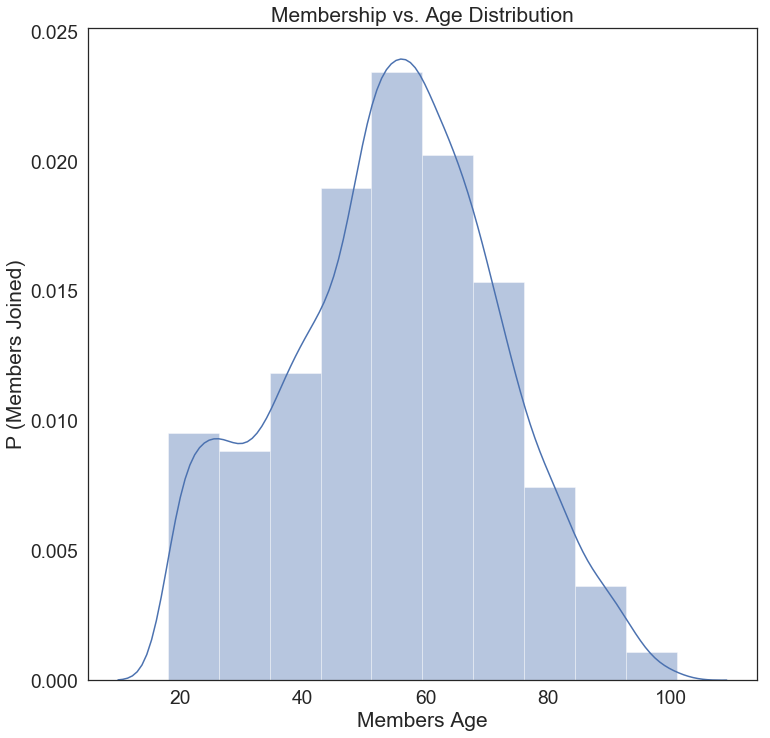

In [72]:
sns.distplot(profile1['age'], bins=10)

plt.xlabel('Members Age')
plt.ylabel('P (Members Joined)')
plt.title('Membership vs. Age Distribution')
#plt.legend(title='Gender', loc='upper left', labels=['Female', 'Male'])



#### OBSERVATION

The above graph shows that most of the members are between 50 and 70 years of age. This gives us a clue that people in that age range have more disposable income to be able to spend $5 for a small morning coffee.

### transcript Dataset EDA

This dataset contains the following, as shown below.

1. event - any of the following: [transaction, offer received, offer viewed, offer completed]

2. person - customer_id 
3. time - time starts from t=0
4. value - offer id or transaction amount



In [73]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [74]:
event_counts = transcript['event'].value_counts()
event_counts.head()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [75]:
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)), columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [76]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [77]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

### Cleaning the dataset

Now we have to clean our datset and make the following changes.

1. person -> customer_id
2. To keep the data consistent, we convert time in hours to days
3. Rename the variable "time" to "timedays".
4. Only keep those customers who are already in our customer profile Dataset
5. Build two separate datasets, for customers and one for transactions 

For this data cleaning process we will use a function to perform all the cleaning action on our dataset.

This will make the code compact and simpler.

In [78]:
import os
import re

In [79]:
def clean_transcript(profile, data_dir = './data'):
   
    transcript = pd.read_json(os.path.join(data_dir,'transcript.json'),orient='records',
                              lines=True)

    # Change 'person' column to 'customer_id'
    transcript.columns = update_column_name(transcript,'person','customer_id')

    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customer_id'].isin(profile['customer_id'])
    transcript = transcript[select_data]

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript, 'time','timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda i: pattern_obj.match(i) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offer_id', 'customer_id', 'timedays']

    # Create an offer_id column
    offer_data['offer_id'] = offer_data['value'].apply(lambda i: list(i.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda i: pattern_obj.match(i).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] =transaction['value'].apply(lambda i: list(i.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event', 'value'])
    column_order = ['customer_id', 'timedays', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction

def update_column_name(dataframe, old_column_name, new_column_name):
   
    column_names = dataframe.columns.values
    select_data = np.array([i == old_column_name for i in column_names])
    column_names[select_data] = new_column_name
    
    return column_names


In [80]:
offer_data, transaction = clean_transcript(profile)

Percentage of transactions removed: 12.31 %


In [81]:
offer_data.head()

,offer_id,customer_id,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


In [82]:
transaction.head()

,customer_id,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


Now we will combine the transaction, offer_data and demographic datasets to create one big dataset that coombines a customer, their transactions, whether they received any offers or not, whether they completed any offers or not, and merge this information with the other data already included in the main portfolio dataset.

We will call this dataset "final_data".

In [83]:
portfolio.head(10)

,offer_id,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


In [84]:
import progressbar

In [85]:
# Reference
# https://progressbar-2.readthedocs.io/en/latest/

In [130]:
# In order to make code debugging easier, I have created a new function which
# will build a new dataset to be used for further processing

def build_offer_dataset(profile, portfolio, offer_data, transaction):
    new_customer_data_clean = []
    list_of_customer_id = offer_data['customer_id'].unique()
    
    # Custom widget reference documentation:
    # https://progressbar-2.readthedocs.io/en/latest/index.html#introduction
    
    widgets=[' [',
             progressbar.Timer(), '] ',
             progressbar.Bar(),
             ' (',
             progressbar.ETA(),
             ') ']
    progress = progressbar.ProgressBar(widgets=widgets)

    for i in progress(range(len(list_of_customer_id))):

        new_customer_data_clean.extend(make_combined_dataset(list_of_customer_id[i],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction))
    
    """for i in range(len(list_of_customer_id)):

        new_customer_data_clean.extend(make_combined_dataset(list_of_customer_id[i],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction))"""
    

    clean_customer_data = pd.DataFrame(new_customer_data_clean)

    # This is the list of all the columns we want in our new and clean dataset
    # column ordering
    column_ordering = ['time', 'offer_id', 'customer_id', 'totalamount',
                       'offersuccessful', 'difficulty', 'duration',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web', 'gender',
                       'income', 2013, 2014, 2015, 2016, 2017, 2018,
                       '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
                       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)',
                       '[90, 100)', '[100, 110)']

    clean_customer_data = clean_customer_data[column_ordering]

    clean_customer_data = clean_customer_data.sort_values('time')
    
    return clean_customer_data.reset_index(drop=True)



def make_combined_dataset(customer_id, portfolio, profile, offer_data, transaction):
    
    # Select the customer profile from the customer_id input in the function above
    current_customer = profile[profile['customer_id'] == customer_id]

    # Now, we are selecting the offer data from the offer_data table for that 
    # specific customer.
    
    select_offer_data = offer_data['customer_id'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    
    # Once all the data from the customer_id column has been asserted equal to customer_id,
    # we will drop the customer_id column
    customer_offer_data = customer_offer_data.drop(columns='customer_id')
    
    # After making these changes, we will reset the customer_transaction index
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    
    # Now, we select the transactions for the customer above
    select_transaction = transaction['customer_id'] == customer_id
    
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data = customer_transaction_data.drop(columns='customer_id')

    customer_transaction_data = customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    
    event_type = ['completed', 'received', 'viewed']

    # Offerss received
    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    # Offers viewed
    offer_viewed = customer_offer_data[customer_offer_data['viewed'] == 1]
    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    # Offers completed
    offer_completed = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    
    # Now we iterate over each offer that a specific customer receives
    rows = []
    for i in range(offer_received.shape[0]):

        # Initialize the current offer id
        current_offer_id = offer_received.iloc[i]['offer_id']

        # Look-up a description of the current offer
        current_offer = portfolio.loc[portfolio['offer_id'] == current_offer_id]
        durationdays = current_offer['duration'].values[0]

        # Initialize the time period when an offer is valid
        current_offer_startime = offer_received.iloc[i]['timedays']

        current_offer_endtime = offer_received.iloc[i]['timedays'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction = np.logical_and(customer_transaction_data['timedays'] >=
                           current_offer_startime,
                           customer_transaction_data['timedays'] <=
                           current_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed = np.logical_and(offer_completed['timedays'] >= current_offer_startime,
                           offer_completed['timedays'] <= current_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed = np.logical_and(offer_viewed['timedays'] >= current_offer_startime,
                           offer_viewed['timedays'] <= current_offer_endtime)

        # Determine whether the current offer was successful
        current_offer_successful = select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        current_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        current_row = {'offer_id': current_offer_id,
                   'customer_id': customer_id,
                   'time': current_offer_startime,
                   'offersuccessful': int(current_offer_successful),
                   'totalamount': current_offer_transactions['amount'].sum()}

        current_row.update(current_offer.iloc[0,1:].to_dict())

        current_row.update(current_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(current_row)

    return rows


Now, we will check if there is a file called "clean_data.csv" inside the our data directory. If not, then we will create the file. This is a good engineering practice to 

In [135]:
final_production_data_file_csv = "./data/final_production_data_file.csv"

if os.path.exists(final_production_data_file_csv):
    final_production_data = pd.read_csv(final_production_data_file_csv)
else:
    final_production_data = build_offer_dataset(profile,
                                     portfolio,
                                     offer_data,
                                     transaction)

    final_production_data.to_csv(final_production_data_file_csv, index=False)
    
final_production_data = final_production_data.drop(columns=['time',
                                      'customer_id',
                                      'email',
                                      'informational'])

new_column_order = ['offer_id', 'totalamount']
new_column_order.extend([i for i in final_production_data.columns if i not in new_column_order])

final_production_data = final_production_data[new_column_order]
final_production_data.head()

 [Elapsed Time: 0:09:27] |###################################| (Time: 0:09:27) 


,offer_id,totalamount,offersuccessful,difficulty,duration,reward,bogo,discount,mobile,social,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


### OBSERVATION

We have created our clean dataset with all the required columns and features that we need for our further data processing. 


### FURTHER STEPS

Now, we have to perform the following steps;

1. Split the data into test and training sets;
2. Import training models from the sklearn library;
3. Train our dataset on the model;
4. Run the trained model on the testing dataset;
5. Measure the error;
6. Make the model production ready by deploying the model with an API endpoint (we will eliminate this step for this notebook, but the code is ready to be deployed on AWS SageMaker)

## Step 1: Splitting the data into testing and training datasets

In general, we split the training and testing data into 70% - 30%. But depending upon the number of instances we have, we can change this ratio up or down. e.g. if we have 10 million samples, then keeping 3 million samples just for the testing phase makes very little sense. And since we know that the performance of a machine learning model imporves with the amount of data we supply, we can get better results by keeping only ~100k examples in testing set and using the rest of the datasest for training.

Source: Andrew Ng Lecture on YouTube

In [138]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [145]:
# Since we are using the model to predict whether the offer was successfull or not, our label data in this case is "offersuccessful"
# Here in our problem, I will keep 15% data as test set and 85% will be used for training.

class_variables = final_production_data.drop(columns=['offersuccessful'])
class_labels = final_production_data.filter(['offersuccessful'])

# Using 15% data as test data
# choosing random_state = 101 to make the results replicable.

X_train, X_test, y_train, y_test = train_test_split(class_variables.values, class_labels.values, test_size=0.15, random_state=101)

# Getting only the names of the variables/classes after dropping the "offersuccessful" column
variable_names = class_variables.columns[2:]

# Tuning the X_train dataset
# Selecting only the offer_id column from the training dataset
offer_id_train = X_train[:, 0]

# Selecting only the totalamount column from the training dataset
totalamount_train = X_train[:,1]

# Finalizing the training dataset and converting the ints to float64
X_train = X_train[:, 2:].astype('float64')


# Tuning the X_test dataset
# Selecting only the offer_id column from the training dataset
offer_id_test = X_test[:, 0]

# Selecting only the totalamount column from the training dataset
totalamount_test = X_test[:,1]

# Finalizing the training dataset and converting the ints to float64
X_test = X_test[:, 2:].astype('float64')


y_train = y_train.ravel()
y_test = y_test.ravel()


Now, we will calculate which offers were successful by how much. For this, we will create a function called calculate_percentage_success which will create two columns, "count" and "percent_success". These columns will have the total number of offers with the same id and their percentage success.

In [155]:
def calculate_percentage_success():
    successful_count = final_production_data[['offer_id', 'offersuccessful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = final_production_data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offersuccessful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offersuccessful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [156]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,6564,75.289458,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6563,72.741124,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,6488,61.451911,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,6590,54.522003,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6521,51.602515,10,5,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6584,47.995140,5,7,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,6543,47.531713,10,7,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6627,45.510789,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,6561,7.742722,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,6544,6.127751,0,3,0,0,0,1,1,1,1,0


### PLOTS - "customer_received_offers" & "percent of success"

Now, we will generate the plots of how many people received which offers and how many offers were successful.

Text(0, 0.5, 'SUCCESS PERCENTAGE (%)')

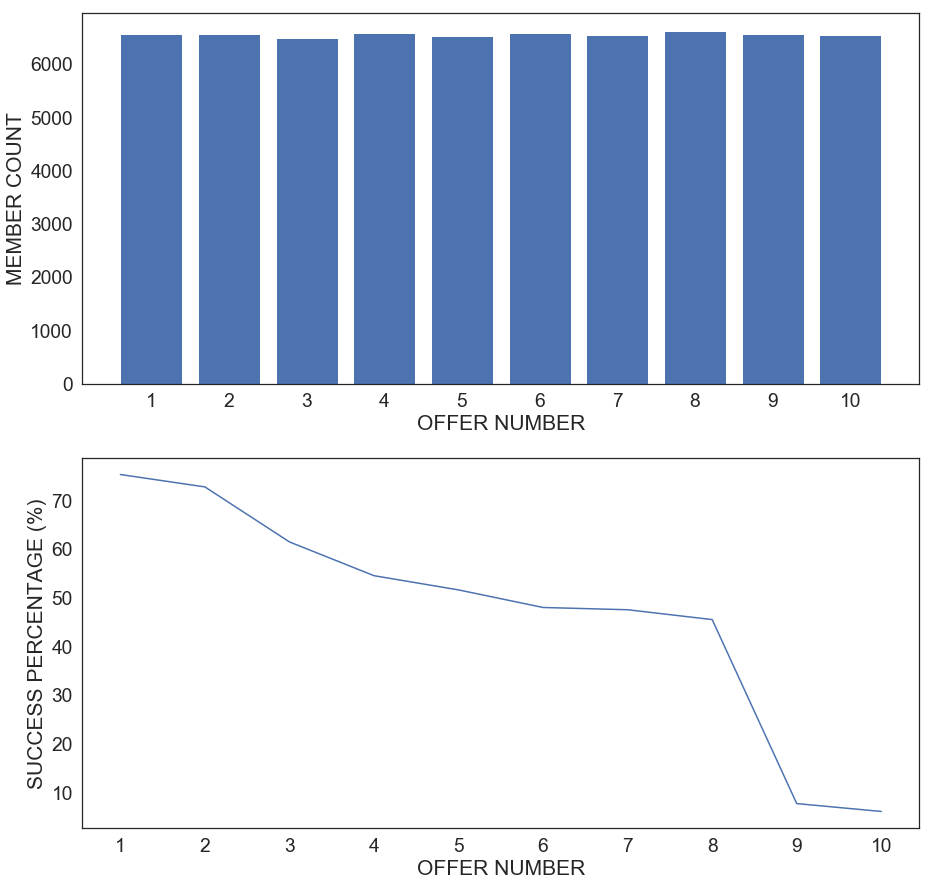

In [160]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=2, ncols=1)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('OFFER NUMBER')
ax[0].set_ylabel('MEMBER COUNT')

ax[1].plot(percent_success.index + 1, percent_success['percent_success'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('OFFER NUMBER')
ax[1].set_ylabel('SUCCESS PERCENTAGE (%)')

### OBSERVATION

From the plots above, we can oberver the following things;

1. Almost all offers were provided equally to ~6600 users.
2. The effetiveness or success of the offers gradually reduced, i.e. the first 6 types of offers were the most successful, while the offers 9 and 10 were the least successful offers. 

The 2 least successful offers are "informational", which is no surprise since I personally will not consider the informational offers to be "offers" per-se. Customers would consider it to be a memo from the company and are least likely to go buy the product immediately after they learned about the product. Considering the nature of Starbucks customers, we know that they are loyal, are more affluent, and want to be confident of their purchase. With only the informational offers, the confidence part seems to be a bit off, hence the offer completion drop off.

## MODEL BUILDING

In order to build our models, we need to import the respective libraries from the sklearn module. 
We have already prepared the data in the cells above.

Form the other projects done in the Udacity's Machine Learning Nanodegree already, I will use 3 different types of models on our dataset.

1. Random Forest
2. Logistic Regression


### MODEL PERFORMANCE BENCHMARK

In order to measure the performance of our models, we should first set our benchmark, against which we will measure the performance of our models.

This benchmark can be either;

    a - How humans make predictions, OR
    b - How a naive system would make predictions.
    
Since we do not have any insights on how a human would predict the outcome of any offer, we will create a naive prediction model.


### NAIVE PREDICTION MODEL

For our naive model, we can import "accuracy_score" and "f1_score" from sklearn and try to run it on the y_train.
This will give us something to work with, and we will benchmark our models on the outcome of this model.

In [161]:
from sklearn.metrics import f1_score, accuracy_score

In [162]:
naive_model_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_model_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive model accuracy: %.3f" % (naive_model_accuracy))
print("Naive model f1-score: %.3f" % (naive_model_f1score))

Naive model accuracy: 0.468
Naive model f1-score: 0.638


### OBSERVATIONS

From the above cell, we can see that the naive model has very low accuracy scores of 46.8% and 63.8%.

Our goal is to beat this benchmark and figure out which of model performs the best.

## MODEL 1: LOGISTIC REGRESSION

First, we will go with a simple classical machine learning model, Logistic Regression. But first, we will import some required libraries and the model itself.


In [164]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [166]:
scoring = make_scorer(fbeta_score, beta=0.5)

# Instantiate and LogisticRegression classifier with a random_state  = 101 to keep the reuslts reproducible
logistic_regression_classifier = LogisticRegression(solver='liblinear', random_state=101)

# I used "liblinear" solver becuse it is the most suited for smaller datasets, like the ones we have. To quote from the LogisticRegression
# details, we have;

"""Algorithm to use in the optimization problem.

    - For small datasets, 'liblinear' is a good choice, whereas 'sag' and
      'saga' are faster for large ones.
    - For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs'
      handle multinomial loss; 'liblinear' is limited to one-versus-rest
      schemes."""

# Building Grid Parameters dict for model tuning
grid_params = {'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]}

logistic_regression_random = RandomizedSearchCV(estimator=logistic_regression_classifier,
                                                param_distributions = grid_params,
                                                scoring=scoring,
                                                n_iter=10,
                                                n_jobs=3,
                                                cv = 3,
                                                verbose=2,
                                                random_state=101,
                                                )

logistic_regression_random.fit(X_train, y_train)

C:\Users\muham\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    7.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=101, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

Now, after running the model, we will evaluate our model.

In [171]:
def evaluate_model_performance(logistic_regression_classifier, X_train, y_train):
    class_name = re.sub("[<>']", '', str(logistic_regression_classifier.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = logistic_regression_classifier.predict(X_train)

    logistic_regression_classifier_accuracy = accuracy_score(y_train, y_pred_rf)
    logistic_regression_classifier_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, logistic_regression_classifier_accuracy))
    print("%s model f1-score: %.3f" % (class_name, logistic_regression_classifier_f1_score))
    
    return logistic_regression_classifier_accuracy, logistic_regression_classifier_f1_score

In [172]:
evaluate_model_performance(logistic_regression_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.721
LogisticRegression model f1-score: 0.714


(0.7207562738802088, 0.7139207938987411)

### OBSERVATION

Using a simple Logistic Regression Model on our dataset has performed exceedingly well.

We had the following performance metrics for naive model;
    1. Accuracy - 46.8%
    2. F1 Score - 63.8%
    
And with Logistic Regression Model, we have;
    1. Accuracy - 72.1%
    2. F1 Score - 71.4%

This clearly shows that out of the two models, we should clearly use Logistic Regression.

# MODEL 2: RANDOM FOREST

Now, we will construct a Random Forest Classifier model. 

First, we have to import the Random Forest Classifier Model from sklearn.

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [175]:
# Just like we did above, we will instantiate our Random Foreset Classifier model
# We will use random_state=101 to make the results reproducible. We can use any number here.

random_forest_classifier = RandomForestClassifier(random_state=101)

n_estimators = [10,50,100,150,200,250,300,350,400]

max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Fine tuning our classifier
random_forest_random = RandomizedSearchCV(estimator = random_forest_classifier,
                               param_distributions = random_grid,
                               scoring=scoring,
                               n_iter = 100,
                               n_jobs = 3,
                               cv = 3,
                               verbose=2,
                               random_state=101)
                               

random_forest_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   46.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  6.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=101, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [177]:
# Random Forest Classifier model's performance
evaluate_model_performance(random_forest_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.742
RandomForestClassifier model f1-score: 0.734


(0.7420130231223205, 0.7338145474736257)

In [178]:
# Now, we will evaluate the performance on the test dataset and check whether our model overfitted or underfitted.

evaluate_model_performance(random_forest_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.739
RandomForestClassifier model f1-score: 0.735


(0.7386663956088636, 0.734921125889267)

The performance of the training and testing dataset is very close which means that our model did not over or under fit.

### OBSERVATION

Using Random Forest Model on our dataset has performed teh best so far.

We had the following performance metrics for naive model;
    1. Accuracy - 46.8%
    2. F1 Score - 63.8%
    
And with Logistic Regression Model, we have;
    1. Accuracy - 72.1%
    2. F1 Score - 71.4%

And with Random Forest Model, we have;
    1. Accuracy - 74.2%
    2. F1 Score - 73.4%
    
This clearly shows that out of all the models, Random Forest Classifier works the best.

In my experience, I have seen that Random Forest Classifiers have worked best for classicial machine learning problems, especially when we do not have a lot of data. If we have a lot of data available, then we can use Deep Learning Models which "tend" to perform better than classical machine learning models. Also, the definition of a "lot" of data varies with the scope of the problem to be solved.

## PROJECT RUNDOWN AND CONCLUSION

1. I took the raw data and performed the data exploration.
2. I then performed data cleaning on the data. This was the longest and the most challenging tast of them all.
3. I then did feature engineering on the categorical variables and converted them in to either one-hot-encoded variables or converted them into MultiLabelBinarizer as explained above. 
4. I performed data cleaning on all given datasets and converted them into usable datasets, good enough to perform machine learning on them.
5. Then I combined all the datasets into one final project dataset (mega dataset) to perform our actual machine learning tasks.
6. I then split the data into test and training datasets with 85% training data and 15% testing data.
7. Then I ran 2 models, Logistic Regression and Random Forest Classification, and compared them against a naive benchmark model which assumes that all the offers were successful.
8. After performing all the tests, I compared the results of all models and selected the Random Forest Classifier for our production and further tuning.

The problem that we started our projects with was very simple - "Will a customer respond to a certain offer?". 

This lead us to a rabbit trail of data cleaning and importing a number of different packages to perform certain tasks throughout the process.


### WHY ONLY F1-SCORE AND ACCURACY FOR BENCHMARK?

I selected "accuracy" and "F1-score" to be the benchmark metrics because first of all, it is a classification problem. 
Second, the F1-score is a harmonic mean of "precision" and "recall", which eliminates the need to benchmark those metrics individually.

In the model of choice, Random Forest Classifier, if I had more data then I could have trained the model for even longer and fine tuned the hyperparameters evern more. Because machine learning models depend on a lot of data, I might have been able improve the F1 scores and accuracy.

Finally, this is not the final form of the project/model in any way. I could have spent a LOT more time on making different combinations and refining the model but in the interest of time, I am stopping here.

There is a fine line between doing the project "enough" and getting something out of it, vs. "mastering" the project and getting the best result "after" it was needed. This line is arbitrary and varies for all projects. As a machine learning engineer, we must keep this line in mind all the time.